In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import datetime
#import statsmodels.api as sm
sns.set()
%matplotlib inline
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')

In [3]:
news = pd.read_csv('./Dataset/News_Final.csv',parse_dates=['PublishDate'])
fe = pd.read_csv('./Dataset/Facebook_Economy.csv')

In [4]:
year_distribute = news.PublishDate.apply(lambda x : x.year)
year_distribute.value_counts()

2016    72662
2015    20574
2012        1
2008        1
2002        1
Name: PublishDate, dtype: int64

In [5]:
#keep the news that is on all three platforms
F = news[news['Facebook']>0].Facebook
L = news[news['LinkedIn']>0].LinkedIn
G = news[news['GooglePlus']>0].GooglePlus
news['num_platform'] = news["Facebook"].map(str) + ',' + news["GooglePlus"].map(str)+  ',' + news['LinkedIn'].map(str)
news['num_platform'] = news['num_platform'].apply(lambda x: [int(num) for num in x.split(',')])
news['num_platforms'] = news['num_platform'].apply(lambda x: 3 - x.count(-1)-x.count(0))
news_df = news[news['num_platforms']==3]

#generate datetime columns for further use
news_df['Publish_Year'] = news_df.PublishDate.apply(lambda x : x.year)
news_df['Publish_Month'] = news_df.PublishDate.apply(lambda x : x.month)
news_df['Publish_Day'] = news_df.PublishDate.apply(lambda x : x.day)
news_df['Publish_weekday'] = news_df.PublishDate.apply(lambda x : x.weekday())

### Explore the distribution of news sources

Text(0, 0.5, '#Source')

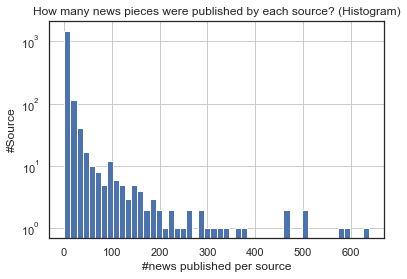

In [17]:
news_df.Source.value_counts().hist(bins = 50)
plt.yscale('log')
plt.title('How many news pieces were published by each source? (Histogram)')
plt.xlabel('#news published per source')
plt.ylabel('#Source')

#### Where do the news come from?
1. 750/1732 sources have only 1 piece of news published.
2. 1300/1732 sources have only less than 6 news published.

In [19]:
news_df.Source.value_counts()[:5]

The Guardian      637
Bloomberg         597
New York Times    582
Reuters           509
Forbes            501
Name: Source, dtype: int64

### Create categorical labels for source rank

In [6]:
# Create a column that categorizes the influence of the sources
# The assumption is those sources with little news publications are less influential 
# so that we can build connection between #news and the size of this source to define how influential the sources is.
# But before that, we need to check if there is relationship between the source and popularity.

source_df = pd.DataFrame(news_df.Source.value_counts())
thrsd_1 = int(len(source_df)*0.01) #17
thrsd_5 = int(len(source_df)*0.05) #69
thrsd_20 = int(len(source_df)*0.2) #260 #the rest: 1386 
#Justify: I chose 20% as threshold because after 20%, 
#post per souces is lower than 10, which can be considered as a low-frequency-post number.  
source_df['source_rank'] = source_df['Source'].apply(lambda x: np.nan)
source_df['source_rank'][:thrsd_1]= 'Top_1%'
source_df['source_rank'][thrsd_1:thrsd_5]= 'Top_5%'
source_df['source_rank'][thrsd_5:thrsd_20]= 'Top_20%'
source_df['source_rank'][thrsd_20:] = 'Others'

source_df = source_df.reset_index()
source_df.columns = ['Source', 'num_post','source_rank']
source_df.head(5)

,Source,num_post,source_rank
0,The Guardian,637,Top_1%
1,Bloomberg,597,Top_1%
2,New York Times,582,Top_1%
3,Reuters,509,Top_1%
4,Forbes,501,Top_1%


In [7]:
source_check = news_df.merge(source_df, on = 'Source')
platform = 'GooglePlus'
source_check.groupby('source_rank')[platform].mean().sort_values(ascending = False)
#Findings: Not like the two others, the most popular post in GooglePlus is in top5%. 

source_rank
Top_5%     14.902669
Top_1%     13.203089
Top_20%    10.660349
Others      6.619079
Name: GooglePlus, dtype: float64

In [8]:
top_1_f = np.log(source_check[source_check['source_rank']=='Top_1%'][platform])
top_5_f = np.log(source_check[source_check['source_rank']=='Top_5%'][platform])
top_20_f = np.log(source_check[source_check['source_rank']=='Top_20%'][platform])
top_other_f = np.log(source_check[source_check['source_rank']=='Others'][platform])

Text(0.5, 1.0, 'GooglePlus')

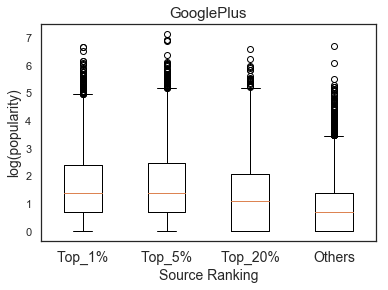

In [9]:
plt.boxplot([top_1_f, top_5_f, top_20_f,top_other_f]);
plt.xticks([1,2,3,4],['Top_1%', 'Top_5%', 'Top_20%','Others'], fontsize = 14);
plt.xlabel('Source Ranking',fontsize = 14)
plt.ylabel('log(popularity)',fontsize = 14)
plt.title('%s'%platform, fontsize = 15)

### Create categorical labels for news popularity

In [14]:
thrsd_1 = int(len(news_df)*0.01) #17
thrsd_5 = int(len(news_df)*0.05) #69
thrsd_25 = int(len(news_df)*0.25)

def cal_thrsd(column):
    column = column.sort_values(ascending = False)
    return column.iloc[thrsd_1], column.iloc[thrsd_5], column.iloc[thrsd_25] 

facebook_thrsd = cal_thrsd(news_df.Facebook)
google_thrsd = cal_thrsd(news_df.GooglePlus)
link_thrsd = cal_thrsd(news_df.LinkedIn)

def create_rank(x, thrsd):
    if x>=thrsd[0]:
        return 'Top_1%'
    elif x>= thrsd[1]:
        return 'Top_5%'
    elif x>= thrsd[2]:
        return 'Top_25%'
    else:
        return 'Others'
    
news_df['Face_pop_rank'] = news_df['Facebook'].apply(lambda x: create_rank(x, facebook_thrsd))
news_df['Google_pop_rank'] = news_df['GooglePlus'].apply(lambda x: create_rank(x, google_thrsd))
news_df['LinkedIn_pop_rank'] = news_df['LinkedIn'].apply(lambda x: create_rank(x, link_thrsd))

In [15]:
news_df = news_df.merge(source_df, on = 'Source')

In [16]:
#Of all the top 1% popular news on facebook, how many of them are from different popularity rank of source? 
news_df[news_df['Face_pop_rank']=='Top_25%'].source_rank.value_counts()

Top_5%     1830
Top_1%     1561
Top_20%     966
Others      328
Name: source_rank, dtype: int64

In [274]:
news_df[news_df['Google_pop_rank']=='Top_25%'].source_rank.value_counts()

Top_5%     1941
Top_1%     1592
Top_20%     957
Others      301
Name: source_rank, dtype: int64

In [275]:
news_df[news_df['LinkedIn_pop_rank']=='Top_25%'].source_rank.value_counts()

Top_1%     1761
Top_5%     1733
Top_20%     824
Others      428
Name: source_rank, dtype: int64

In [277]:
news_df[news_df['Face_pop_rank']=='Top_1%'].Source.value_counts()

Breitbart News      35
New York Times      21
Fox News            19
Washington Post     12
Daily Caller         8
                    ..
Fortune              1
RushLimbaugh.com     1
Examiner.com         1
Military Times       1
snopes.com           1
Name: Source, Length: 75, dtype: int64

In [278]:
news_df[news_df['Face_pop_rank']=='Top_1%'].Topic.value_counts()

obama        210
economy       15
palestine      6
microsoft      3
Name: Topic, dtype: int64

In [281]:
news_df[news_df['LinkedIn_pop_rank']=='Top_5%'].Source.value_counts()

New York Times       126
Business Insider      80
ZDNet                 48
Bloomberg             46
TechCrunch            44
                    ... 
Seeking Alpha          1
AdExchanger            1
ArcticStartup          1
CRN Australia          1
Technology Review      1
Name: Source, Length: 169, dtype: int64

In [234]:
news_df[news_df['Google_pop_rank']=='Top_1%'].Source.value_counts()

The Verge                     22
Breitbart News                16
Fox News                      14
PoliticusUSA                  13
New York Times                13
                              ..
Detroit Free Press             1
The Weekly Standard (blog)     1
ZDNet                          1
Democracy Now!                 1
CNET                           1
Name: Source, Length: 82, dtype: int64

In [165]:
news_df[news_df['LinkedIn_pop_rank']=='Top_1%'].Topic.value_counts()

economy      102
microsoft     99
obama         32
palestine      1
Name: Topic, dtype: int64

In [163]:
news_df[news_df['Face_pop_rank']=='Top_1%'].sort_values(by = 'Facebook', ascending = False)

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,...,num_platforms,Publish_Year,Publish_Month,Publish_Day,Publish_weekday,Face_pop_rank,Google_pop_rank,LinkedIn_pop_rank,num_post,source_rank
15665,72143.0,Fact Check: Top 10 Lies in Obama's State of th...,President Barack Obama promised his final Stat...,Breitbart News,obama,2016-01-13 05:44:47,0.118585,-0.144500,40836,210,...,3,2016,1,13,2,Top_1%,Top_1%,Top_25%,289,Top_5%
2190,76901.0,I Miss Barack Obama,"As this primary season has gone along, a stran...",New York Times,obama,2016-02-09 08:32:36,-0.125000,0.168878,32385,276,...,3,2016,2,9,1,Top_1%,Top_1%,Top_5%,582,Top_1%
2067,12561.0,"For the Wealthiest, a Private Tax System That ...","A. Winters, a political scientist at Northwes...",New York Times,economy,2015-12-29 17:00:23,-0.113067,-0.104257,29564,774,...,3,2015,12,29,1,Top_1%,Top_1%,Top_1%,582,Top_1%
15631,67508.0,"Paul Ryan Betrays America: $1.1 Trillion, 2000...","Obama's executive action, known as Deferred Ac...",Breitbart News,obama,2015-12-17 05:44:45,0.265165,0.100051,22518,425,...,3,2015,12,17,3,Top_1%,Top_1%,Top_25%,289,Top_5%
8812,35873.0,Microsoft's 'teen girl' AI turns into a Hitler...,"Developers at Microsoft created 'Tay', an AI m...",Telegraph.co.uk,microsoft,2016-03-24 09:53:54,-0.144338,-0.019137,22346,973,...,3,2016,3,24,3,Top_1%,Top_1%,Top_1%,145,Top_5%
20220,65424.0,Obama Hires Former Hamas Terrorist For His ISI...,A radical foreign policy adviser fired by Pres...,Liberty News Now,obama,2015-12-04 16:24:39,-0.041667,-0.104257,19136,196,...,3,2015,12,4,4,Top_1%,Top_1%,Others,1,Others
20996,67141.0,President Obama Singing Hotline Bling Is...,"With his head on Drake's body, we even get a g...",Global Grind,obama,2015-12-15 17:04:49,-0.013176,-0.056751,17170,13,...,3,2015,12,15,1,Top_1%,Top_25%,Top_25%,1,Others
10316,23117.0,"Under Sanders, income and jobs would soar, eco...",Those are just a few of the things that would ...,CNNMoney,economy,2016-02-08 17:40:27,-0.041667,0.069317,16993,1267,...,3,2016,2,8,0,Top_1%,Top_1%,Top_5%,70,Top_5%
15449,90713.0,Why Obama's crack down on corporate mergers is...,Hail to the chief. President Obama is giving b...,Fox News,obama,2016-04-16 21:55:10,-0.061051,-0.243403,16598,1,...,3,2016,4,16,5,Top_1%,Others,Others,285,Top_5%
18541,94081.0,Obama Frees USS Cole Bombing Terrorist,Sabri was rated as a high risk terrorist who i...,FrontPage Magazine,obama,2016-05-02 00:00:00,-0.102062,-0.436657,15692,49,...,3,2016,5,2,0,Top_1%,Top_25%,Others,14,Top_20%


In [ ]:
# Simple classification model
# RNN 